Imports and setup:

In [1]:
import re
import sys
import csv
import pandas as pd
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
#nltk.download('stopwords')
#nltk.download('wordnet')

pd.set_option('display.max_colwidth', 100)
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()


PATHS:

In [2]:
#irony speech:
IRONY_RAW_PATH = '../datasets/irony/raw/'
IRONY_INTERIM_PATH = '../datasets/irony/interim/'

#emoji:
EMOJI_RAW_PATH = '../datasets/emoji/raw/'
EMOJI_INTERIM_PATH = '../datasets/emoji/interim/'

FILES:

In [3]:
TEST = 'test_text.txt'
TRAIN = 'train_text.txt'
VAL = 'val_text.txt'

TEST_LABELS = 'test_labels.txt'
TRAIN_LABELS = 'train_labels.txt'
VAL_LABELS = 'val_labels.txt'


TEST_INTERIM = 'test_seperated.csv'
TRAIN_INTERIM = 'train_seperated.csv'
VAL_INTERIM = 'val_seperated.csv'

Functions

In [4]:
def tokenize(line):
    """A function that takes input and tokenizes the input
    """
    # Initialise lists
    tokens = []
    unmatchable = []

    # Compile patterns for speedup
    token_pat = re.compile(r'\w+|#+|\'|@|\.\.+|!+|\?+')
    skippable_pat = re.compile(r',|\|http://t.co/+')  # typically spaces

    # As long as there's any material left...
    while line:
        # Try finding a skippable token delimiter first.
        skippable_match = re.search(skippable_pat, line)
        if skippable_match and skippable_match.start() == 0:
            # If there is one at the beginning of the line, just skip it.
            line = line[skippable_match.end():]
        else:
            # Else try finding a real token.
            token_match = re.search(token_pat, line)
            if token_match and token_match.start() == 0:
                #print(line[token_match.start():token_match.end()])
                if line[token_match.start():token_match.end()] == '#':
                    # keep hash tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        else:
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == '@':
                    # keep @ tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == "'":
                    # handle contractions as a single word
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                # If there is one at the beginning of the line, tokenize it
                else:
                    tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
            else:
                # Else there is unmatchable material
                # It ends where a skippable or token match starts, or at the end of the line.
                unmatchable_end = len(line)
                if skippable_match:
                    unmatchable_end = skippable_match.start()
                if token_match:
                    unmatchable_end = min(unmatchable_end, token_match.start())
                # Add it to unmatchable and discard from line.
                unmatchable.append(line[:unmatchable_end])
                line = line[unmatchable_end:]

    final_tokens = []

    while len(tokens) > 0:
        temp1 = tokens.pop(0)
        try:
            temp2 = tokens.pop(0)
            if temp2[0] == "'":
                temp1 += temp2
                final_tokens.insert(0, temp1)
            else:
                final_tokens.insert(0, temp1)
                tokens.insert(0, temp2)
        except:
            final_tokens.insert(0, temp1)
        
    final_tokens = final_tokens[::-1]

    return final_tokens

In [5]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = tokenize(text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

Read-in and set up dataframe

In [6]:
data = pd.read_csv(IRONY_RAW_PATH+TRAIN, delimiter="\n", names=['body_text'])
data['label'] = pd.read_csv(IRONY_RAW_PATH+TRAIN_LABELS, delimiter="\n", dtype='int')

data = data[:2861]

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

data_val = pd.read_csv(IRONY_RAW_PATH+VAL, delimiter="\n", names=['body_text'])
data_val['label'] = pd.read_csv(IRONY_RAW_PATH+VAL_LABELS, delimiter="\n", dtype='int')

data_val = data_val[:954]

data_val['body_len'] = data_val['body_text'].apply(lambda x: len(x) - x.count(" "))
data_val['punct%'] = data_val['body_text'].apply(lambda x: count_punct(x))


X_train = data[['body_text','body_len', 'punct%']]
X_test = data_val[['body_text','body_len', 'punct%']]

y_train = data['label']
y_test = data_val['label']

data.head()

,body_text,label,body_len,punct%
0,seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life,0.0,70,1.4
1,"look for the girl with the broken smile, ask her if she wants to stay while, and she will be lov...",1.0,81,3.7
2,Now I remember why I buy books online @user #servicewithasmile,1.0,53,3.8
3,@user @user So is he banded from wearing the clothes? #Karma,1.0,50,8.0
4,Just found out there are Etch A Sketch apps. #oldschool #notoldschool,1.0,59,5.1


In [7]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640
0,70,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,81,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,3.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,5.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
from sklearn.metrics import classification_report,\
confusion_matrix, accuracy_score, plot_confusion_matrix, recall_score
import matplotlib.pyplot as plt

In [14]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=0, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 2.39 / Predict time: 0.125 ---- Precision: 0.543 / Recall: 0.501 / Accuracy: 0.519


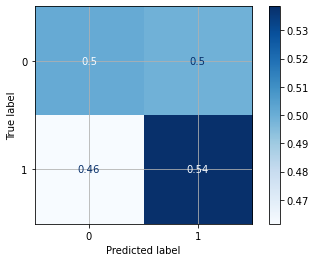

In [15]:
# Plot the confusion matrix for the SGD classifier model
fig, ax = plt.subplots()
plot_confusion_matrix(rf_model, X_test_vect, y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)

plt.grid(None)

plt.show();

In [16]:
print(y_test.sum())
y_pred.sum()

455.0


494.0

In [17]:
bob = SGDClassifier(loss='log',shuffle=False)

start = time.time()
bob_model = bob.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = bob_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=0, average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 3.368 / Predict time: 0.068 ---- Precision: 0.75 / Recall: 0.006 / Accuracy: 0.479


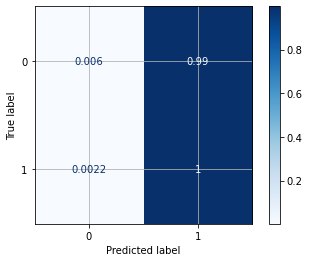

In [18]:
# Plot the confusion matrix for the SGD classifier model
fig, ax = plt.subplots()
plot_confusion_matrix(bob_model, X_test_vect, y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)

plt.grid(None)

plt.show();

In [19]:
print(y_test.sum())
y_pred.sum()

455.0


950.0